In [48]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import sys, getopt
import csv
import pickle
import copy

from tqdm import tqdm


pd.set_option('display.max_rows', 500)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
import seaborn as sns
sns.set_style("darkgrid")

import umap
from sklearn.decomposition import TruncatedSVD as tsvd

def nearZeroVarDropAuto(df,thresh=0.99):
    vVal=df.var(axis=0).values
    cs=pd.Series(vVal).sort_values(ascending=False).cumsum()
    remove=cs[cs>cs.values[-1]*thresh].index.values
    return df.drop(df.columns[remove],axis=1)

%run SodaKick_download_functions.ipynb

import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD, Adagrad, Adam, Adagrad
import torch.nn as nn
import torch.nn.functional as F

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.multioutput import MultiOutputRegressor

In [75]:
#note xgboost can handle missing values internally
#list of parameters:
#https://xgboost.readthedocs.io/en/latest/parameter.html

#custom obj functions
#https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html
#https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

In [4]:
class matchesDataset(Dataset):

    """ Extend pytorch Dataset class to include cleaning and training set creation, """
    
    def __init__(self, matches, results):

        self.matches = torch.tensor(matches, dtype=torch.float32)
        self.results = torch.tensor(results, dtype=torch.float32)

    def __len__(self):

        """ Returns the len of the training sample. """
        
        return len(self.matches)
        

    def __getitem__(self, index): 

        """ Returns a word, a context word and a list of negative words for training for a given index. 

        Args:
            index (int): index for the word selection.

        Returns:
            (string, string, list of strings): selected word, context word and a randomly drawn list 
                                               of negative words.

        """
        return self.matches[index], self.results[index]

In [85]:
#https://towardsdatascience.com/quirky-keras-custom-and-asymmetric-loss-functions-for-keras-in-r-a8b5271171fe
def WSE(output, target, a=1.5, b=.5):
    loss = torch.mean(a*torch.minimum(torch.zeros(output.shape[1]),output - target)**2+\
                      b*torch.maximum(torch.zeros(output.shape[1]),output - target)**2)      
    return loss

def WSEl1(output, target, a=1.5, b=.5):
    loss = torch.mean(a*torch.abs(torch.minimum(torch.zeros(output.shape[1]),output - target))+\
                      b*torch.abs(torch.maximum(torch.zeros(output.shape[1]),output - target)))      
    return loss

def WSE2(output, target, a=1.5, b=.5):
    loss = np.mean(a*np.minimum(np.zeros(output.shape[0]),output - target)**2+\
                      b*np.maximum(np.zeros(output.shape[0]),output - target)**2)      
    return loss

def WSEl12(output, target, a=1.5, b=.5):
    loss = np.mean(a*np.abs(np.minimum(np.zeros(output.shape[0]),output - target))+\
                      b*np.abs(np.maximum(np.zeros(output.shape[0]),output - target)))      
    return loss

In [5]:
from sklearn import preprocessing

    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_inp_2a.pkl', 'rb') as pk:
    inp=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_out_2a.pkl', 'rb') as pk:
    out=pickle.load(pk)     
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_inp_2b.pkl', 'rb') as pk:
    inpb=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_out_2b.pkl', 'rb') as pk:
    outb=pickle.load(pk)     

inp=np.concatenate([inp,inpb])
out=np.concatenate([out,outb])

def normalize_mins(vec):
    for i in range(vec.shape[0]):
        vec[i][::8]=vec[i][::8]/90

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def NormalizeMatrix(data):   
    for i in range(data.shape[1]):
        data[:,i] = NormalizeData(data[:,i])
        
NormalizeMatrix(inp)
np.nan_to_num(inp, copy=False)

normalize_mins(out)

#scaler = preprocessing.StandardScaler().fit(inp)
#inp = scaler.transform(inp)

//miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [122]:
from typing import Tuple

def WSE(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    
    target = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    
    a=1.5
    b=.5
    
    elements = a*np.minimum(np.zeros(len(predt)),predt - target)**2+\
                      b*np.maximum(np.zeros(len(predt)),predt - target)**2
    
    return 'WSE', float(np.sqrt(np.sum(elements) / len(target)))

# cross valid

[18:04:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:04:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:04:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_16197

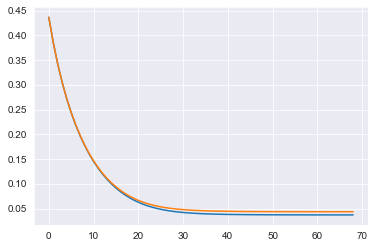

In [123]:
data_dmatrix = xgb.DMatrix(data=inp,label=out[:,0])
params = {"objective":"reg:pseudohubererror", 'colsample_bytree': 0.3, 'learning_rate': 0.1,
                'max_depth': 7, 'alpha': 10, 'eta' : 0.3, 'gamma' : 0, 'lambda' : 1, 
          'n_estimators' : 1000}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=100, early_stopping_rounds=10, feval=WSE, metrics='rmse', as_pandas=True, seed=32)

#plt.fill_between(np.arange(len(cv_results)),cv_results['train-rmse-mean']+cv_results['train-rmse-std'],cv_results['train-rmse-mean']-cv_results['train-rmse-std'], alpha=.2)
plt.plot(cv_results['train-rmse-mean'])
#plt.fill_between(np.arange(len(cv_results)), cv_results['test-rmse-mean']+cv_results['test-rmse-std'],cv_results['test-rmse-mean']-cv_results['test-rmse-std'], alpha=.2)
plt.plot(cv_results['test-rmse-mean'])

print(cv_results['test-rmse-mean'].iloc[-1],cv_results['test-WSE-mean'].iloc[-1])

[18:06:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:06:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:06:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_16197

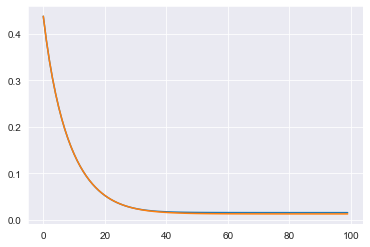

In [126]:
data_dmatrix = xgb.DMatrix(data=inp,label=out[:,1])
params = {"objective":"reg:pseudohubererror", 'colsample_bytree': 0.3, 'learning_rate': 0.1,
                'max_depth': 7, 'alpha': 10, 'eta' : 0.3, 'gamma' : 0, 'lambda' : 1, 
          'n_estimators' : 1000}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=100, early_stopping_rounds=10, feval=WSE, metrics='rmse', as_pandas=True, seed=32)

#plt.fill_between(np.arange(len(cv_results)),cv_results['train-rmse-mean']+cv_results['train-rmse-std'],cv_results['train-rmse-mean']-cv_results['train-rmse-std'], alpha=.2)
plt.plot(cv_results['train-rmse-mean'])
#plt.fill_between(np.arange(len(cv_results)), cv_results['test-rmse-mean']+cv_results['test-rmse-std'],cv_results['test-rmse-mean']-cv_results['test-rmse-std'], alpha=.2)
plt.plot(cv_results['test-rmse-mean'])

print(cv_results['test-rmse-mean'].iloc[-1],cv_results['test-WSE-mean'].iloc[-1])

In [144]:
model = MultiOutputRegressor(
    XGBRegressor(**params))

model.fit(inp, out)

//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


MultiOutputRegressor(estimator=XGBRegressor(alpha=10, base_score=None,
                                            booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.3, eta=0.3,
                                            gamma=0, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            lambda=1, learning_rate=0.1,
                                            max_delta_step=None, max_depth=7,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
       

In [149]:
pred=model.predict(inp)

In [151]:
print('Baseline WSE: {:.3f}'.format(WSE2(np.array([0]*out[0].shape[0]),out[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(np.array([0]*out[0].shape[0]),out[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(np.array([0]*out[0].shape[0]),out[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(np.array([0]*out[0].shape[0]),out[0], a=1, b=1)))

print((out[1]-out[10]).sum())
print((out[50]-out[60]).sum())
print((out[100]-out[110]).sum())

Baseline WSE: 617.929
Baseline WSE l1: 7.481
Baseline MSE: 411.952
Baseline MSE l1: 4.987
1940.0
16.566666666666666
2.0000000000000004


In [152]:
print('Baseline WSE: {:.3f}'.format(WSE2(pred[0],out[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(pred[0],out[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(pred[0],out[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(pred[0],out[0], a=1, b=1)))

print((pred[1]-pred[10]).sum())
print((pred[50]-pred[60]).sum())
print((pred[100]-pred[110]).sum())

Baseline WSE: 151.189
Baseline WSE l1: 3.687
Baseline MSE: 100.793
Baseline MSE l1: 2.463
960.1405
14.047673
-0.13421345


In [154]:
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[3])
print(byteamframe)
reframe, byteamframe = revert_output(out[3])
print(byteamframe)

      goals   assists  cards_yellow  cards_red  own_goals  goals_against  \
0  3.184194  3.569660      3.641780   0.051267   0.050593       0.998421   
1  1.044025  0.884132      2.059382   0.063297   0.055173       4.067022   

      saves  
0  1.937445  
1  1.946247  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0    4.0      4.0           4.0        0.0        0.0            1.0    2.0
1    1.0      1.0           2.0        0.0        0.0            4.0    2.0
